In [14]:
%matplotlib inline

from ROOT import TFile,vector,TGraph
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import json

import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats

In [10]:
# first make run1 open data/MC dataframes
def bless_tune1_reweight(row):
    rw = float(1)
    if row['nu_interaction_mode']==1001 and (row['nu_pdg']==14 or row['nu_pdg']==-14):
        rw = xsec_tune1_graph_numu.Eval(row['MC_energyInit']) / xsec_mcc9_graph_numu.Eval(row['MC_energyInit'])
    if row['nu_interaction_mode']==1001 and (row['nu_pdg']==12 or row['nu_pdg']==-12):
        rw = xsec_tune1_graph_nue.Eval(row['MC_energyInit']) / xsec_mcc9_graph_nue.Eval(row['MC_energyInit'])
    return rw

good_df = pd.read_csv('../data/goodruns_2020.txt')
good_df['good'] = 1
RSE=['run','subrun','event']

df_data = read_root('/media/disk1/kmason/mcc9_v28_wctagger_5e19_finalbdt.root','dlana/FinalVertexVariables')
print (len(df_data))
print('Loaded files')
df_data = df_data.join(good_df.set_index('run'),on='run')
beamq_df = read_root('../data/beamdataquality_remix_bnb5e19.root','bdq')
df_data = df_data.join(beamq_df.set_index(['run','subrun','event']),on=['run','subrun','event'])

df_bnb = read_root('/media/disk1/kmason/mcc9_v28_wctagger_bnboverlay_finalbdt.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_bnb_nu_run1.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)
print('Loaded Files')
df_bnb = df_bnb.join(good_df.set_index('run'),on='run')


print("number of data events:",len(df_data))
print("number of MC events:",len(df_bnb))

46311
Loaded files
161015
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1

In [11]:
# add in delta variable for cut 
# these functions work on individual df

def gamma4vectorshower1(df,energy_v):
    allvectors = []
    for idx in range(0,len(df)):
        energy = energy_v[idx]
        xdir = df['shower1_dir_3d_X'].values[idx]
        ydir = df['shower1_dir_3d_Y'].values[idx]
        zdir = df['shower1_dir_3d_Z'].values[idx]
        #check magnitude
        mag = sqrt(xdir*xdir+ydir*ydir+zdir*zdir)
        if (mag != 0):
            singlevector = [energy,(xdir/mag)*energy,(ydir/mag)*energy,(zdir/mag)*energy]
        else:
            singlevector = [-9999,-9999,-9999,-9999]
        allvectors.append(singlevector)
    return allvectors

def gamma4vectorshower2(df,energy_v):
    allvectors = []
    for idx in range(0,len(df)):
        energy = energy_v[idx]
        xdir = df['shower2_dir_3d_X'].values[idx]
        ydir = df['shower2_dir_3d_Y'].values[idx]
        zdir = df['shower2_dir_3d_Z'].values[idx]
        #check magnitude
        mag = sqrt(xdir*xdir+ydir*ydir+zdir*zdir)
        if (mag != 0):
            singlevector = [energy,(xdir/mag)*energy,(ydir/mag)*energy,(zdir/mag)*energy]
        else:
            singlevector = [-9999,-9999,-9999,-9999]
        allvectors.append(singlevector)
    return allvectors

# now turn them into pi0 vectors
def pi04vector(shower1,shower2):
    allvectors = []
    for evt in range(len(shower1)):
        shower1_v = shower1[evt]
        shower2_v = shower2[evt]
        if(shower1_v[0] > -9999 and shower1_v[0] > -9999):
            singlevector = [shower1_v[0]+shower2_v[0],shower1_v[1]+shower2_v[1],shower1_v[2]+shower2_v[2],shower1_v[3]+shower2_v[3]]
        else:
            singlevector = [-9999,-9999,-9999,-9999]
        allvectors.append(singlevector)
    return allvectors

# make proton 4 vector
def proton4vector(df):
    allvectors = []
    for idx in range(0,len(df)):
        energy = df['Proton_Edep'].values[idx]+938
        momentum = 0
        if (energy>0):
            momentum = sqrt(energy*energy -(938*938))
        theta = df['Proton_ThetaReco'].values[idx]
        phi = df['Proton_PhiReco'].values[idx]
        xdir = sin(theta)*cos(phi)
        ydir = sin(theta)*sin(phi)
        zdir = cos(theta)
        #check magnitude
        mag = sqrt(xdir*xdir+ydir*ydir+zdir*zdir)
        singlevector = [energy,(xdir/mag)*momentum,(ydir/mag)*momentum,(zdir/mag)*momentum]
        allvectors.append(singlevector)
    return allvectors

def delta4vector(proton,pi0):
    allvectors = []
    for evt in range(len(proton)):
        energy = proton[evt][0]+pi0[evt][0]
        momx = proton[evt][1]+pi0[evt][1]
        momy = proton[evt][2]+pi0[evt][2]
        momz = proton[evt][3]+pi0[evt][3]
        if (pi0[evt][0] >-9999):
            singlevector = [energy,momx,momy,momz]
        else:
            singlevector = [-9999,-9999,-9999,-9999]
        allvectors.append(singlevector)
    return allvectors

# get delta rest mass

def deltarestmass(delta):
    restmass = 0
    mass_v=[]
    for evt in range(len(delta)):
        energy = delta[evt][0]
        momx = delta[evt][1]
        momy = delta[evt][2]
        momz = delta[evt][3]
        mom = 0
        if (momx >0 or momy>0 or momz>0):
            mom = sqrt(momx*momx+momy*momy+momz*momz)
        if (energy >-9999):
            mass = sqrt(energy*energy-mom*mom)
        else:
            mass = -9999
        mass_v.append(mass)
    return mass_v

shower1 = gamma4vectorshower1(df_data,df_data['shower1_E_Y'].values)
shower2 = gamma4vectorshower2(df_data,df_data['shower2_E_Y'].values)
pi0 = pi04vector(shower1,shower2)
proton = proton4vector(df_data)
delta = delta4vector(proton,pi0)
mass = deltarestmass(delta)
df_data['DeltaMass'] = mass

shower1 = gamma4vectorshower1(df_bnb,df_bnb['shower1_E_Y'].values)
shower2 = gamma4vectorshower2(df_bnb,df_bnb['shower2_E_Y'].values)
pi0 = pi04vector(shower1,shower2)
proton = proton4vector(df_bnb)
delta = delta4vector(proton,pi0)
mass = deltarestmass(delta)
df_bnb['DeltaMass'] = mass

In [12]:
# make pi0 cuts
cuts = 'good ==1 and PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass<400 and DeltaMass >0 and DeltaMass <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass>0 and BDTscore_1e1p<.7'
RSE = ['run','subrun','event']
sort = 'shower1_E_Y'

df_bnb_pi0 = df_bnb.query(cuts)
df_bnb_pi0 = df_bnb_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_pi0 = df_data.query(cuts)
df_data_pi0 = df_data_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

print("number of data events:" ,len(df_data_pi0))
print("number of MC events:" ,len(df_bnb_pi0))

number of data events: 147
number of MC events: 1460


In [17]:
# now find matching SSNet info df['averageshowerscore']
#load in json files with info...
f_bnb= open("../data/ssnet_bnb_overlay_run1.json", "r")
ssnet_bnb = json.load(f_bnb)
f_data= open("../data/ssnet_5e19.json", "r")
ssnet_data = json.load(f_data)

def getssnet(df,ssnet):
    print(len(df))
    #get the ssnet variables from the json info files
    avg_shower = []
#     loop through selected events
    for x in range(len(df)):
        if (x % 50 == 0):
            print(x)
        df_run = df['run'].values[x]
        df_subrun = df['subrun'].values[x]
        df_event = df['event'].values[x]
        found = False;
#         now loop through json to find matching r,s,e
        for i in range(len(ssnet["entries"])):
            if found ==False:
                ssnet_run = ssnet["entries"][i]["run"]
                ssnet_subrun = ssnet["entries"][i]["subrun"]
                ssnet_event = ssnet["entries"][i]["event"]
                # check to see if json entry matches df entry
                if (ssnet_run ==df_run and ssnet_subrun ==df_subrun and ssnet_event ==df_event ):
                    found = True
#                     then save shower score
                    avg_shower.append(ssnet['entries'][i]['SSNetShowerAverage'])
                    
        if found == False:
            avg_shower.append(-9999)

            
    return avg_shower

shower_bnb = getssnet(df_bnb_pi0,ssnet_bnb)
shower_data = getssnet(df_data_pi0,ssnet_data)
df_data_pi0['SSNetShowerAverage']= shower_data
df_bnb_pi0['SSNetShowerAverage']= shower_bnb


1460
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
147
0
50
100


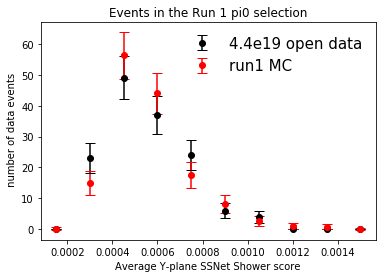

In [37]:
# make plot - unit normalized
var_data = df_data_pi0["SSNetShowerAverage"].values
var_bnb = df_bnb_pi0["SSNetShowerAverage"].values

# turn into histograms
data_Hist,binedges = np.histogram( var_data, bins = 10, range = [0,0.0015],density = False)
bnb_Hist,_ = np.histogram( var_bnb, bins = 10, range = [0,.0015],density = False)

bnb_Hist_norm=[float(i)*float(len(df_data_pi0)/len(df_bnb_pi0)) for i in bnb_Hist]

bincenters = np.ones(len(binedges)-1)
for i in range(len(binedges)-1):
    bincenters[i] = binedges[i]+(.0015/10.0)

# make error bars
err_data = [sqrt(float(i)) for i in data_Hist]
err_bnb = [sqrt(float(i)) for i in bnb_Hist_norm]

plt.errorbar(bincenters,data_Hist, yerr=err_data,  fmt='o', color = 'black', ecolor='black', capsize=5,label = '4.4e19 open data')
plt.errorbar(bincenters,bnb_Hist_norm, yerr=err_bnb,  fmt='o', color = 'red', ecolor='red', capsize=5,label = 'run1 MC')

plt.legend(loc='upper right',fontsize=15,frameon=False,ncol=1)
plt.xlabel("Average Y-plane SSNet Shower score")
plt.ylabel(" number of data events")
plt.title("Events in the Run 1 pi0 selection")
plt.show()
plt.close()